# Build a Conditional GAN

### Goals
In this notebook, you're going to make a conditional GAN in order to generate hand-written images of digits, conditioned on the digit to be generated (the class vector). This will let you choose what digit you want to generate.

## Getting Started

For this assignment, you will be using the MNIST dataset.

Note that this assignment requires no changes to the architectures of the generator or discriminator, only changes to the data passed to both. The generator will no longer take `z_dim` as an argument, but  `input_dim` instead, since you need to pass in both the noise and class vectors.

You will begin by importing the necessary libraries and building the generator and discriminator.

#### Packages and Visualization

In [10]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

#### Generator and Noise

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
                #### END CODE HERE ####
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

#### Discriminator

In [3]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels of the output image, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )


    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
                #### END CODE HERE ####
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Class Input

In conditional GANs, the input vector for the generator will also need to include the class information. The class is represented using a one-hot encoded vector where its length is the number of classes and each index represents a class. The vector is all 0's and a 1 on the chosen class. Given the labels of multiple images (e.g. from a batch) and number of classes, please create one-hot vectors for each label. There is a class within the PyTorch functional library that can help you.

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">get_one_hot_labels</font></code></b>
</font>
</summary>

1.   This code can be done in one line.
2.   The documentation for [F.one_hot](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.one_hot) may be helpful.

</details>

In [4]:
import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    #### START CODE HERE ####
    one_hot_labels = F.one_hot(labels, num_classes=n_classes)
    return one_hot_labels
    #### END CODE HERE ####

Next, you need to be able to concatenate the one-hot class vector to the noise vector before giving it to the generator. You will also need to do this when adding the class channels to the discriminator.

To do this, you will need to write a function that combines two vectors. Remember that you need to ensure that the vectors are the same type: floats. Again, you can look to the PyTorch library for help.
<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">combine_vectors</font></code></b>
</font>
</summary>

1.   This code can also be written in one line.
2.   The documentation for [torch.cat](https://pytorch.org/docs/master/generated/torch.cat.html) may be helpful.
3.   Specifically, you might want to look at what the `dim` argument of `torch.cat` does.

</details>

In [5]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector.
        In this assignment, this will be the noise vector of shape (n_samples, z_dim),
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    # Note: Make sure this function outputs a float no matter what inputs it receives
    #### START CODE HERE ####
    combined = torch.cat((x.float(), y.float()), dim=1)
    #### END CODE HERE ####
    return combined

## Training
Now you can start to put it all together!

*   mnist_shape: the number of pixels in each MNIST image, which has dimensions 28 x 28 and one channel (because it's black-and-white) so 1 x 28 x 28
*   n_classes: the number of classes in MNIST (10, since there are the digits from 0 to 9)

In [6]:
mnist_shape = (1, 28, 28)
n_classes = 10

  *   criterion: the loss function (use appropriate loss function)
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type

In [7]:
#### START CODE HERE ####
criterion = nn.BCELoss()
#### END CODE HERE ####

n_epochs = 40
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 152591016.26it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 135196086.86it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47634370.82it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2437375.74it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Then, you can initialize your generator, discriminator, and optimizers. To do this, you will need to update the input dimensions for both models. For the generator, you will need to calculate the size of the input vector; recall that for conditional GANs, the generator's input is the noise vector concatenated with the class vector. For the discriminator, you need to add a channel for every class.

In [8]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns:
        generator_input_dim: the input dimensionality of the conditional generator,
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''
    #### START CODE HERE ####
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0]
    #### END CODE HERE ####
    return generator_input_dim, discriminator_im_chan

In [9]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)
gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Now to train, you would like both your generator and your discriminator to know what class of image should be generated. There are a few locations where you will need to implement code.

For example, if you're generating a picture of the number "1", you would need to:
  
1.   Tell that to the generator, so that it knows it should be generating a "1"
2.   Tell that to the discriminator, so that it knows it should be looking at a "1". If the discriminator is told it should be looking at a 1 but sees something that's clearly an 8, it can guess that it's probably fake

Epoch :  0
generator loss:  tensor(1.0192, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3883, device='cuda:0', grad_fn=<AddBackward0>)


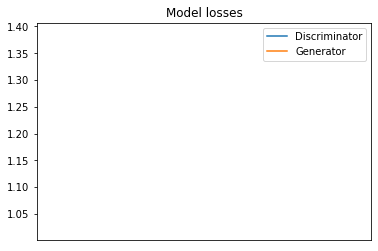

Epoch :  10
generator loss:  tensor(0.7888, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3876, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  20
generator loss:  tensor(0.7627, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3835, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  30
generator loss:  tensor(0.7764, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3796, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  40
generator loss:  tensor(0.7972, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3714, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  50
generator loss:  tensor(0.7996, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3732, device='cuda:0', grad_fn=<AddBackward0>)


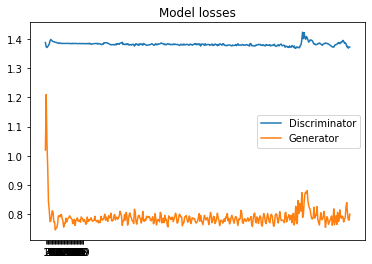

Epoch :  60
generator loss:  tensor(0.7678, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3766, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  70
generator loss:  tensor(0.8051, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3760, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  80
generator loss:  tensor(0.8037, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3892, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  90
generator loss:  tensor(0.7123, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3462, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  100
generator loss:  tensor(0.7940, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3807, device='cuda:0', grad_fn=<AddBackward0>)


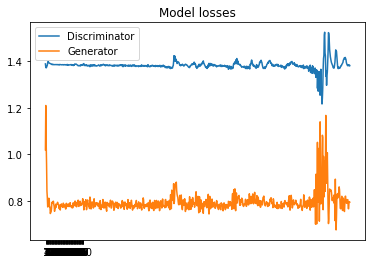

Epoch :  110
generator loss:  tensor(0.8126, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3922, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  120
generator loss:  tensor(0.7497, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3580, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  130
generator loss:  tensor(0.8191, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3821, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  140
generator loss:  tensor(0.8066, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3369, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  150
generator loss:  tensor(0.8156, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3758, device='cuda:0', grad_fn=<AddBackward0>)


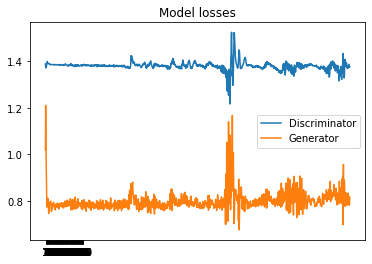

Epoch :  160
generator loss:  tensor(0.8741, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.1788, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  170
generator loss:  tensor(0.8952, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3399, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  180
generator loss:  tensor(0.8021, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3877, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  190
generator loss:  tensor(0.7868, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3412, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  200
generator loss:  tensor(1.0226, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3224, device='cuda:0', grad_fn=<AddBackward0>)


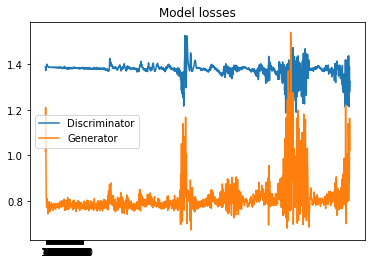

Epoch :  210
generator loss:  tensor(0.8007, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3651, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  220
generator loss:  tensor(0.8466, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3767, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  230
generator loss:  tensor(0.8645, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.2826, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  240
generator loss:  tensor(1.4327, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.1411, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  250
generator loss:  tensor(0.8599, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3483, device='cuda:0', grad_fn=<AddBackward0>)


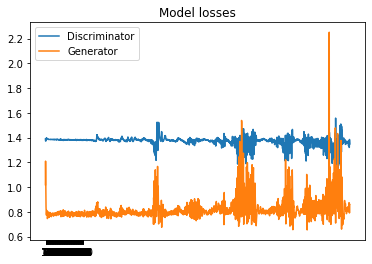

Epoch :  260
generator loss:  tensor(0.8261, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3501, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  270
generator loss:  tensor(0.8040, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3691, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  280
generator loss:  tensor(0.8314, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3723, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  290
generator loss:  tensor(0.8098, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3671, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  300
generator loss:  tensor(0.7990, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3918, device='cuda:0', grad_fn=<AddBackward0>)


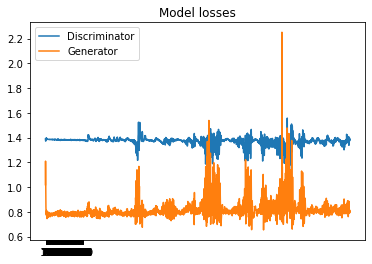

Epoch :  310
generator loss:  tensor(0.8267, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3747, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  320
generator loss:  tensor(0.7832, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3780, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  330
generator loss:  tensor(0.8412, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3675, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  340
generator loss:  tensor(0.9161, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3716, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  350
generator loss:  tensor(0.8655, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3681, device='cuda:0', grad_fn=<AddBackward0>)


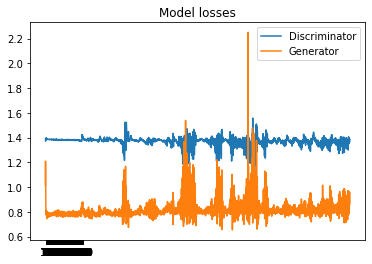

Epoch :  360
generator loss:  tensor(0.9787, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3254, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  370
generator loss:  tensor(0.7531, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3927, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  380
generator loss:  tensor(0.8807, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.2932, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  390
generator loss:  tensor(0.9592, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.2829, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  400
generator loss:  tensor(0.8314, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3238, device='cuda:0', grad_fn=<AddBackward0>)


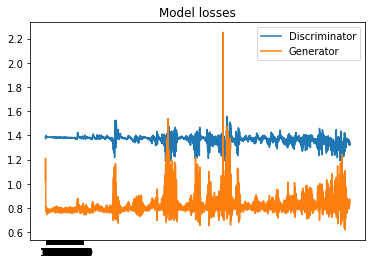

Epoch :  410
generator loss:  tensor(0.9919, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.2845, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  420
generator loss:  tensor(0.8850, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.4000, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  430
generator loss:  tensor(0.9996, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.2560, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  440
generator loss:  tensor(1.0592, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3233, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  450
generator loss:  tensor(1.0505, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.2924, device='cuda:0', grad_fn=<AddBackward0>)


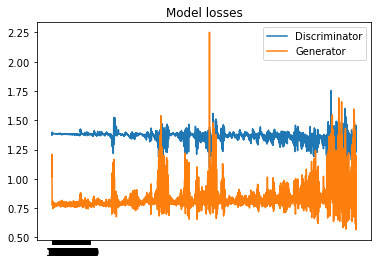

In [ ]:
cur_step = 0
generator_losses = []
discriminator_losses = []


noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)

        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)

        # Now you can get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images

        #### START CODE HERE ####
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)
        #### END CODE HERE ####

        # Make sure that enough images were generated
        assert len(fake) == len(real)

        # Now you can get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator
        #           a) Combine the fake images with image_one_hot_labels,
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Get the discriminator's prediction on the reals as disc_real_pred

        #### START CODE HERE ####
        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        disc_real_pred = disc(real_image_and_labels)
        #### END CODE HERE ####

        # Make sure that enough predictions were made
        assert len(disc_real_pred) == len(real)
        # Make sure that the inputs are different
        assert torch.any(fake_image_and_labels != real_image_and_labels)

        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]
        #
        gen_mean = sum(generator_losses[-display_step:]) / display_step
        disc_mean = sum(discriminator_losses[-display_step:]) / display_step
        '''
       if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()'''
        if(epoch%10 == 0 ):
                    #self.save(masks,images,fake_images,self.output_dir,epoch )
                    print('Epoch : ', epoch)
                    print("generator loss: ",gen_mean)
                    print("discriminator loss: ",disc_mean)
        if(epoch%50 ==0 ):
                    plt.title("Model losses")
                    plt.plot(discriminator_losses, label="Discriminator")
                    plt.plot(generator_losses, label="Generator")
                    plt.xticks(np.arange(1, epoch+1, 1.0))
                    plt.legend()
                    plt.show()

        cur_step += 1